# BMKG/WEATHER TIME SERIES MODELING USING LSTM

## LICENSE

Copyright (c) 2022 Taruma Sakti Megariansyah

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

## SETUP

### PREPARING LIBRARY

In [ ]:
!pip install windrose -q # for plotting windrose
!pip install hidrokit -q # for data preprocessing tensor input (time series LSTM)

     |████████████████████████████████| 44 kB 2.1 MB/s 


In [ ]:
# IMPORT ALL NECESSARY LIBRARY

import numpy as np
import pandas as pd # pandas 1.4.x: req python >=3.8
import plotly.express as px
import plotly.io as pio
import shutil
import tensorflow as tf
import hidrokit
import windrose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from google.colab import drive
from pathlib import Path
from windrose import WindroseAxes
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from hidrokit.contrib.taruma import hk53

In [ ]:
# https://stackoverflow.com/a/49199019
# Answer: Package for listing version of packages used in a Jupyter notebook
# by Alex P. Miller
# https://creativecommons.org/licenses/by-sa/4.0/

import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

tensorflow==2.8.2+zzzcolab20220719082949
scikit-learn==1.0.2
plotly==5.5.0
pathlib==1.0.1
pandas==1.3.5
numpy==1.21.6
keras==2.8.0
google==2.0.3


### MOUNT

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### CONFIGURATION

In [ ]:
# plotly configuration
pio.templates.default = 'plotly_white'

In [ ]:
# ISI PATH_TO_FOLDER DENGAN ALAMAT LOKASI "FOLDER" BMKG_2
PATH_TO_FOLDER = '/content/drive/MyDrive/Colab Notebooks/COURSES/MLT2/BMKG_2'

FOLDER_DEMODAY = Path(PATH_TO_FOLDER)
BMKGZIP_PATH = FOLDER_DEMODAY / 'BMKG.zip'
FOLDER_DATASET = Path('./dataset') # temporary
FOLDER_DATASET.mkdir(parents=True, exist_ok=True)

### DATASET

In [ ]:
# EXTRACT/UNPACK ARCHIVE
shutil.unpack_archive(BMKGZIP_PATH, FOLDER_DATASET)

In [ ]:
 # VIEW FILES IN DATASET
FILES_IN_DATASET = sorted(list(FOLDER_DATASET.glob('*.*')))
print(FILES_IN_DATASET)

[PosixPath('dataset/openweatherdata-denpasar-1990-2020.csv'), PosixPath('dataset/openweatherdata-denpasar-1990-2020v0.1.csv')]


In [ ]:
# YANG DIGUNAKAN VERSI v0.1
filepath = FILES_IN_DATASET[1]
print(filepath)

dataset/openweatherdata-denpasar-1990-2020v0.1.csv


## DATA EXPLORATION

In [ ]:
# LOAD AS DATAFRAME
raw_dataset = pd.read_csv(filepath)

In [ ]:
# INFO DATAFRAME
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264924 entries, 0 to 264923
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               264924 non-null  object 
 1   timezone             264924 non-null  int64  
 2   city_name            264924 non-null  object 
 3   lat                  264924 non-null  float64
 4   lon                  264924 non-null  float64
 5   temp                 264924 non-null  float64
 6   temp_min             264924 non-null  float64
 7   temp_max             264924 non-null  float64
 8   pressure             264924 non-null  float64
 9   humidity             264924 non-null  int64  
 10  wind_speed           264924 non-null  float64
 11  wind_deg             264924 non-null  int64  
 12  rain_1h              16286 non-null   float64
 13  rain_3h              16156 non-null   float64
 14  rain_6h              36098 non-null   float64
 15  rain_12h         

In [ ]:
# DROP ALL EMPTY COLUMNS
pre_dataset = raw_dataset.copy().dropna(how='all', axis='columns')
pre_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264924 entries, 0 to 264923
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               264924 non-null  object 
 1   timezone             264924 non-null  int64  
 2   city_name            264924 non-null  object 
 3   lat                  264924 non-null  float64
 4   lon                  264924 non-null  float64
 5   temp                 264924 non-null  float64
 6   temp_min             264924 non-null  float64
 7   temp_max             264924 non-null  float64
 8   pressure             264924 non-null  float64
 9   humidity             264924 non-null  int64  
 10  wind_speed           264924 non-null  float64
 11  wind_deg             264924 non-null  int64  
 12  rain_1h              16286 non-null   float64
 13  rain_3h              16156 non-null   float64
 14  rain_6h              36098 non-null   float64
 15  rain_12h         

Keterangan kolom diperoleh dari [History Bulk](https://openweathermap.org/history-bulk):

column | description | my notes
------ | ----------- | --------
`dt_iso` | Date and time in UTC format | ini harus diubah format ke _timezone_ lokasinya.
`timezone` | Shift in seconds from UTC | bisa ubah `dt_iso` ke _timezone_ lokasi via ini atau pakai `pandas`.
`city_name` | City name | -
`lat` | Geographical coordinates of the location (latitude) | -
`lon` | Geographical coordinates of the location (longitude) | -
`temp` | Temperature | -
`temp_min` | Minimum temperature at the moment. | (use these parameter optionally)
`temp_max` | Maximum temperature at the moment. | (use these parameter optionally)
`pressure` | Atmospheric pressure (on the sea level) | hPa
`humidity` | Humidity | %
`wind_speed` | Wind speed | meter/sec
`wind_deg` | Wind direction | degrees (meteorological)
`rain_1h` | Rain volume for the last hour | mm
`rain_3h` | Rain volume for the last 3 hours | mm
`rain_6h` | Rain volume for the last 6 hours | mm
`rain_12h` | Rain volume for the last 12 hours | mm
`rain_24h` | Rain volume for the last 24 hours | mm
`clouds_all` | Cloudiness | %
`weather_id` | Weather condition id | detail bisa dibaca [disini](https://openweathermap.org/weather-conditions)
`weather_main` | Group of weather parameters | (Rain, Snow, Extreme etc.)
`weather_description` | Weather condition within the group | -
`weather_icon` | Weather icon id | -


## CREATE DATETIME INDEX

In [ ]:
# preview datetime columns
pre_dataset.dt_iso.head()

0    1/1/1990 0:00
1    1/1/1990 1:00
2    1/1/1990 2:00
3    1/1/1990 3:00
4    1/1/1990 4:00
Name: dt_iso, dtype: object

In [ ]:
# convert to datetime
pre_dataset['date'] = pd.to_datetime(pre_dataset.dt_iso, format='%m/%d/%Y %H:%M')
pre_dataset['tz_shift_seconds'] = pd.to_timedelta(pre_dataset.timezone, unit='seconds')

In [ ]:
# convert date to correct timezone
pre_dataset['date_converted'] = (
    (pre_dataset.date + pre_dataset.tz_shift_seconds)
    .dt.tz_localize('Asia/Makassar') # Bali/Denpasar Timezone: Asia/Makassar
)

pre_dataset['date_converted_by_pd'] = (
    pre_dataset.date
    .dt.tz_localize('utc')
    .dt.tz_convert('Asia/Makassar')
)

In [ ]:
# check if converted date/timezone is correct
pd.testing.assert_series_equal(
    pre_dataset.date_converted,
    pre_dataset.date_converted_by_pd,
    check_names=False
)

assert (
    pre_dataset.date_converted.to_list() 
    == pre_dataset.date_converted_by_pd.to_list()
)

In [ ]:
# create date range from start to end
_date_start = pre_dataset.date_converted.iloc[0]
_date_end   = pre_dataset.date_converted.iloc[-1]

print(f"date_start\t= {_date_start.strftime('%Y-%m-%d %H:%M:%S %Z')}")
print(f"date_end\t= {_date_end.strftime('%Y-%m-%d %H:%M:%S %Z')}")

_date_range = pd.date_range(
    _date_start, _date_end, freq='1H',
    closed=None, # deprecated at pandas 1.4.x
    # inclusive='both', # pandas 1.4.x
)

_date_range

date_start	= 1990-01-01 08:00:00 WITA
date_end	= 2020-01-08 07:00:00 WITA


DatetimeIndex(['1990-01-01 08:00:00+08:00', '1990-01-01 09:00:00+08:00',
               '1990-01-01 10:00:00+08:00', '1990-01-01 11:00:00+08:00',
               '1990-01-01 12:00:00+08:00', '1990-01-01 13:00:00+08:00',
               '1990-01-01 14:00:00+08:00', '1990-01-01 15:00:00+08:00',
               '1990-01-01 16:00:00+08:00', '1990-01-01 17:00:00+08:00',
               ...
               '2020-01-07 22:00:00+08:00', '2020-01-07 23:00:00+08:00',
               '2020-01-08 00:00:00+08:00', '2020-01-08 01:00:00+08:00',
               '2020-01-08 02:00:00+08:00', '2020-01-08 03:00:00+08:00',
               '2020-01-08 04:00:00+08:00', '2020-01-08 05:00:00+08:00',
               '2020-01-08 06:00:00+08:00', '2020-01-08 07:00:00+08:00'],
              dtype='datetime64[ns, Asia/Makassar]', length=263136, freq='H')

In [ ]:
# check if length of index is correct with start date -> end date
print(
    f"{'size of date range (by pandas)':30} = {_date_range.size}",
    f"{'size of date_converted column':30} = {pre_dataset.date_converted.size}",
    (
        f"{'difference':30} = "
        f"{abs(_date_range.size - pre_dataset.date_converted.size)}"
    ),
    sep='\n'
)

size of date range (by pandas) = 263136
size of date_converted column  = 264924
difference                     = 1788


In [ ]:
# check "uncorrect data"
# check duplicate
print(
    f"duplicated datetime index = "
    f"{pre_dataset.date_converted.duplicated().sum()}"
)

duplicated datetime index = 1788


In [ ]:
# comparing date index with column (duplicate removed)
(
    pre_dataset.date_converted
    .drop_duplicates()
    .reset_index(drop=True)
    .compare(
        _date_range
        .to_series()
        .reset_index(drop=True)
    )
)

# if empty, datetime column is correct

Empty DataFrame
Columns: [self, other]
Index: []

In [ ]:
# drop duplicates
pre_dataset = pre_dataset.drop_duplicates(subset='date_converted')

## DROP COLUMN

In [ ]:
pre_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263136 entries, 0 to 264923
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype                        
---  ------                --------------   -----                        
 0   dt_iso                263136 non-null  object                       
 1   timezone              263136 non-null  int64                        
 2   city_name             263136 non-null  object                       
 3   lat                   263136 non-null  float64                      
 4   lon                   263136 non-null  float64                      
 5   temp                  263136 non-null  float64                      
 6   temp_min              263136 non-null  float64                      
 7   temp_max              263136 non-null  float64                      
 8   pressure              263136 non-null  float64                      
 9   humidity              263136 non-null  int64                        
 

In [ ]:
# column with single unique value
columns_single_nunique = (
    pre_dataset
    .columns[pre_dataset.nunique() == 1]
    .to_list()
)
columns_single_nunique

['timezone', 'city_name', 'lat', 'lon', 'tz_shift_seconds']

In [ ]:
# rain columns above 3 hours
columns_rain_above_3 = (
    pre_dataset
    .columns[
        pre_dataset
        .columns.str
        .startswith('rain_')
    ][1:]
    .to_list()
)
columns_rain_above_3

['rain_3h', 'rain_6h', 'rain_12h', 'rain_24h']

In [ ]:
# process/temporary date columns
columns_temporary = 'dt_iso date tz_shift_seconds date_converted_by_pd'.split()
columns_temporary

['dt_iso', 'date', 'tz_shift_seconds', 'date_converted_by_pd']

In [ ]:
# weather descrption columns
columns_weather_description = (
    pre_dataset
    .columns[
        pre_dataset
        .columns.str
        .startswith('weather_')
    ][1:]
    .to_list()
)
columns_weather_description

['weather_main', 'weather_description', 'weather_icon']

In [ ]:
# columns to drop
columns_to_drop = [
    *columns_single_nunique,
    *columns_rain_above_3,
    *columns_temporary,
    *columns_weather_description
]
columns_to_drop

['timezone',
 'city_name',
 'lat',
 'lon',
 'tz_shift_seconds',
 'rain_3h',
 'rain_6h',
 'rain_12h',
 'rain_24h',
 'dt_iso',
 'date',
 'tz_shift_seconds',
 'date_converted_by_pd',
 'weather_main',
 'weather_description',
 'weather_icon']

In [ ]:
drop_dataset = (
    pre_dataset
    .drop(columns_to_drop, axis='columns')
    .set_index('date_converted')
    .rename_axis('date')
)

In [ ]:
drop_dataset.head()

temp  temp_min  temp_max  pressure  humidity  \
date                                                                       
1990-01-01 08:00:00+08:00  25.82     25.82     25.82    1010.0        86   
1990-01-01 09:00:00+08:00  26.20     26.20     26.20    1011.0        84   
1990-01-01 10:00:00+08:00  26.45     26.45     26.45    1011.0        84   
1990-01-01 11:00:00+08:00  26.80     26.80     26.80    1011.0        82   
1990-01-01 12:00:00+08:00  27.04     27.04     27.04    1010.0        82   

                           wind_speed  wind_deg  rain_1h  clouds_all  \
date                                                                   
1990-01-01 08:00:00+08:00        1.36       225     0.49          98   
1990-01-01 09:00:00+08:00        2.09       247     0.13          91   
1990-01-01 10:00:00+08:00        2.44       262     0.24          94   
1990-01-01 11:00:00+08:00        2.29       271     0.23          94   
1990-01-01 12:00:00+08:00        1.71       274      NaN          76   

                           weather_id  
date                                   
1990-01-01 08:00:00+08:00         500  
1990-01-01 09:00:00+08:00         500  
1990-01-01 10:00:00+08:00         500  
1990-01-01 11:00:00+08:00         500  
1990-01-01 12:00:00+08:00         803

In [ ]:
drop_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 263136 entries, 1990-01-01 08:00:00+08:00 to 2020-01-08 07:00:00+08:00
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   temp        263136 non-null  float64
 1   temp_min    263136 non-null  float64
 2   temp_max    263136 non-null  float64
 3   pressure    263136 non-null  float64
 4   humidity    263136 non-null  int64  
 5   wind_speed  263136 non-null  float64
 6   wind_deg    263136 non-null  int64  
 7   rain_1h     16284 non-null   float64
 8   clouds_all  263136 non-null  int64  
 9   weather_id  263136 non-null  int64  
dtypes: float64(6), int64(4)
memory usage: 22.1 MB


## CLEAN DATASET

In [ ]:
clean_dataset = drop_dataset.copy()

In [ ]:
# imputation data for rain_1h
clean_dataset.rain_1h = clean_dataset.rain_1h.fillna(0)

In [ ]:
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 263136 entries, 1990-01-01 08:00:00+08:00 to 2020-01-08 07:00:00+08:00
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   temp        263136 non-null  float64
 1   temp_min    263136 non-null  float64
 2   temp_max    263136 non-null  float64
 3   pressure    263136 non-null  float64
 4   humidity    263136 non-null  int64  
 5   wind_speed  263136 non-null  float64
 6   wind_deg    263136 non-null  int64  
 7   rain_1h     263136 non-null  float64
 8   clouds_all  263136 non-null  int64  
 9   weather_id  263136 non-null  int64  
dtypes: float64(6), int64(4)
memory usage: 22.1 MB


## VISUALIZE DATASET

### Using matplotlib

#### Temperature

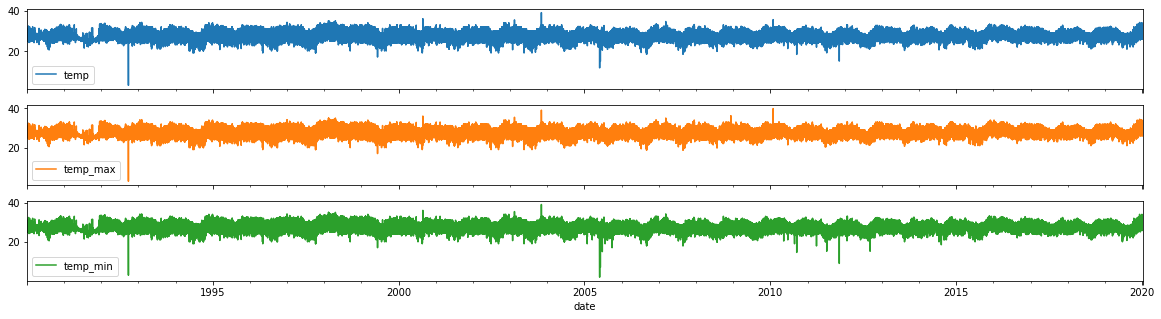

In [ ]:
clean_dataset['temp temp_max temp_min'.split()].plot(subplots=True, figsize=(20, 5));

#### Pressure

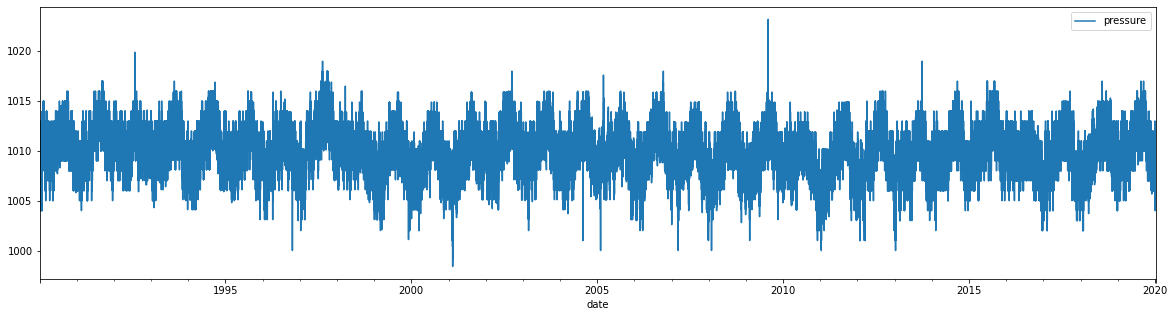

In [ ]:
clean_dataset[['pressure']].plot(figsize=(20, 5));

#### Humidity

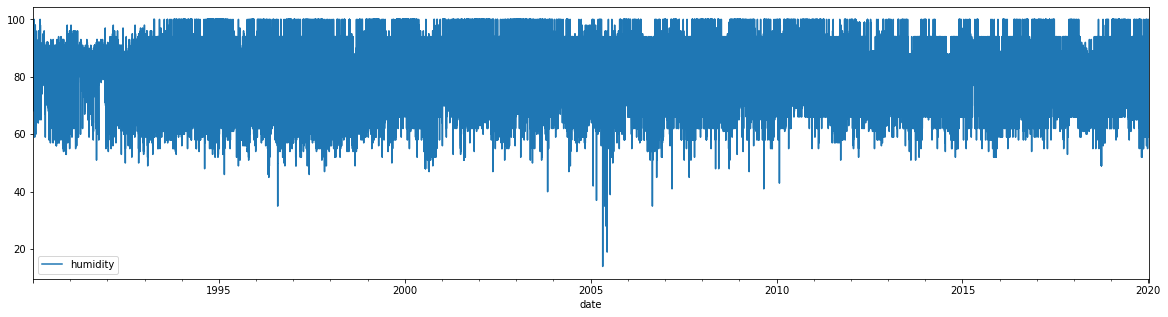

In [ ]:
clean_dataset[['humidity']].plot(figsize=(20, 5));

#### Wind Speed

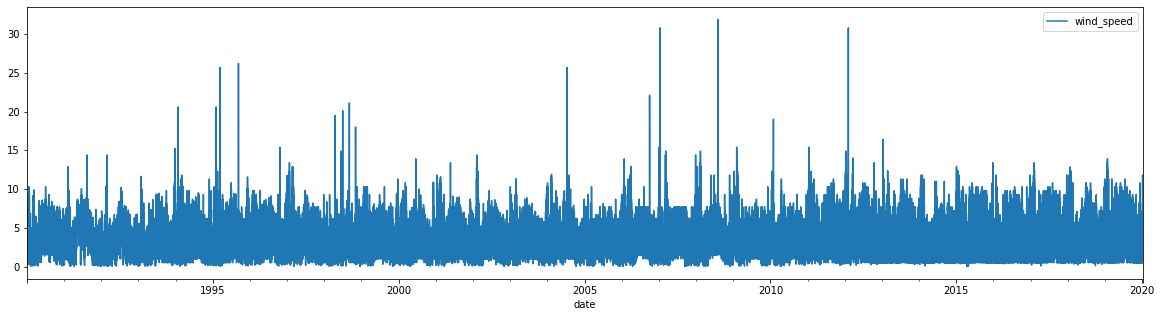

In [ ]:
clean_dataset[['wind_speed']].plot(figsize=(20, 5));

#### Wind Direction

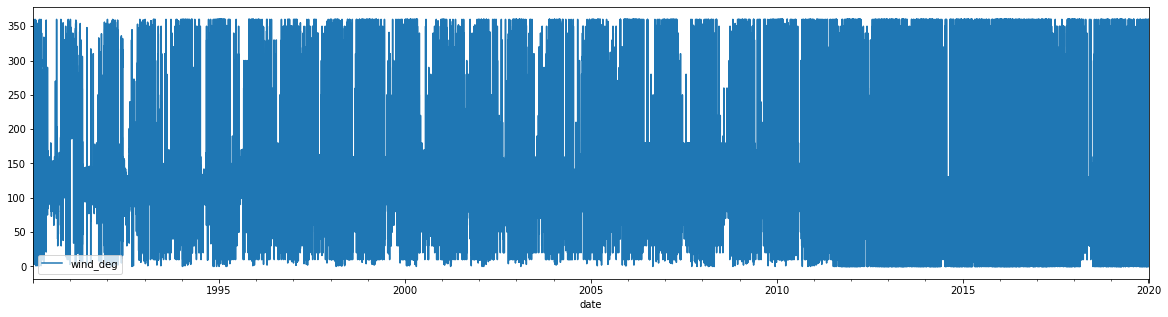

In [ ]:
clean_dataset.wind_deg.to_frame().plot(figsize=(20, 5));

#### Windrose (Wind Degree & Wind Speed)

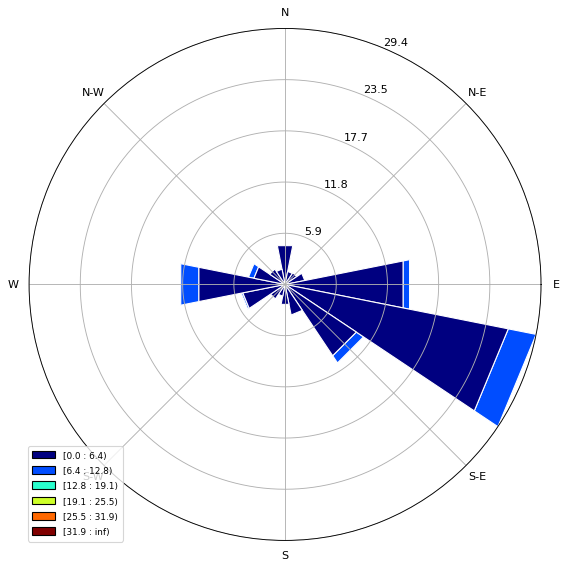

In [ ]:
ax = WindroseAxes.from_ax()
ax.bar(clean_dataset.wind_deg, clean_dataset.wind_speed, normed=True, opening=1, edgecolor='white')
ax.set_legend();

#### Rain (1H)

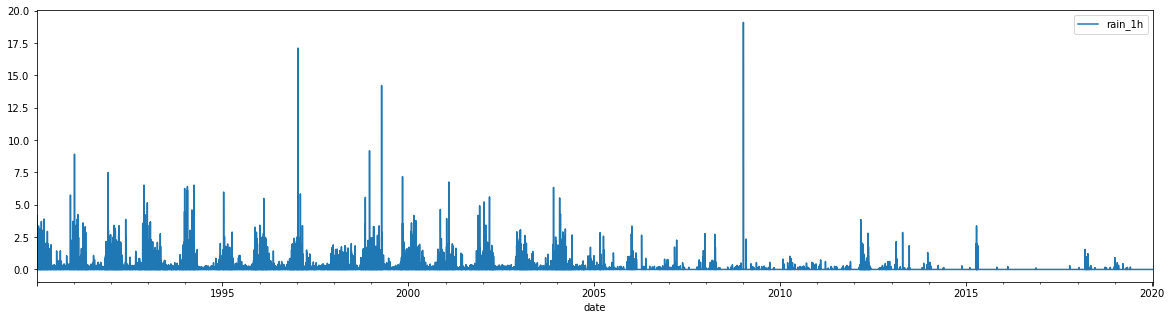

In [ ]:
clean_dataset[['rain_1h']].plot(figsize=(20, 5));

#### Cloudiness

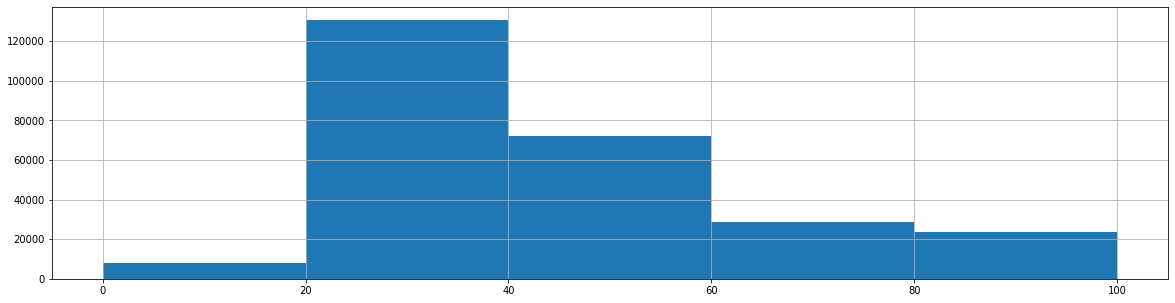

In [ ]:
clean_dataset.clouds_all.hist(bins=100 // 20, figsize=(20, 5));

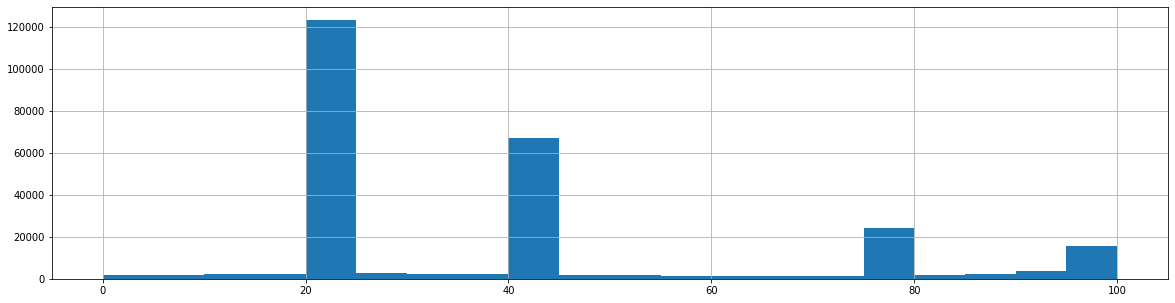

In [ ]:
clean_dataset.clouds_all.hist(bins=100 // 5, figsize=(20, 5));

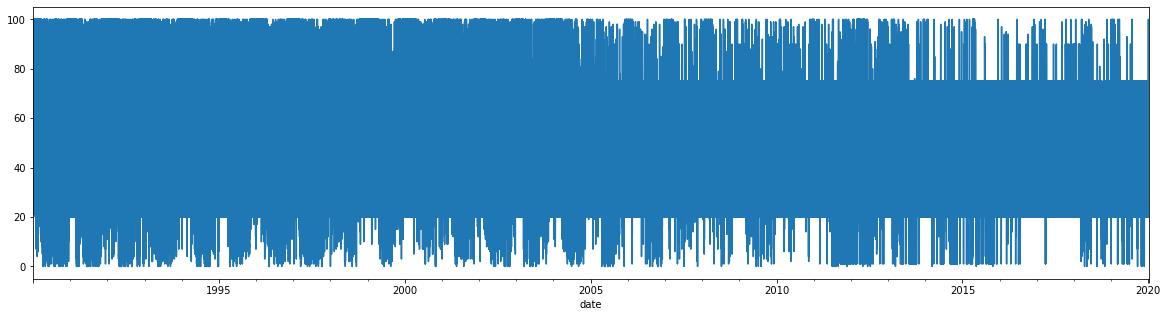

In [ ]:
clean_dataset.clouds_all.plot(figsize=(20, 5));

#### Weather ID

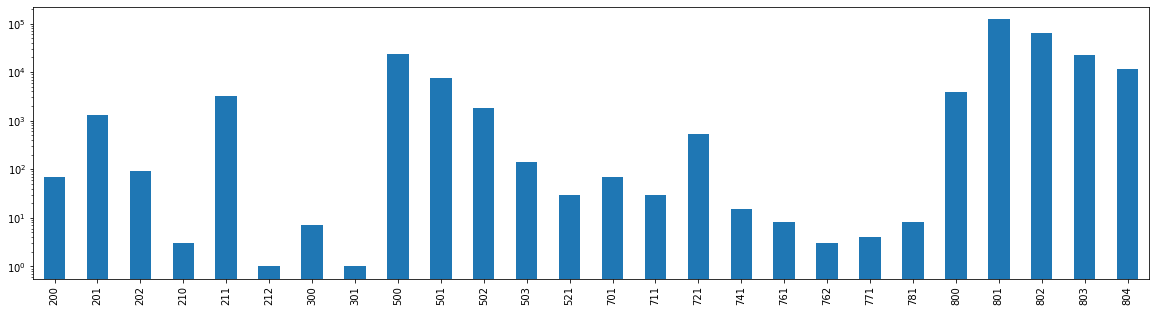

In [ ]:
clean_dataset.weather_id.value_counts().sort_index().plot.bar(figsize=(20, 5), logy=True);

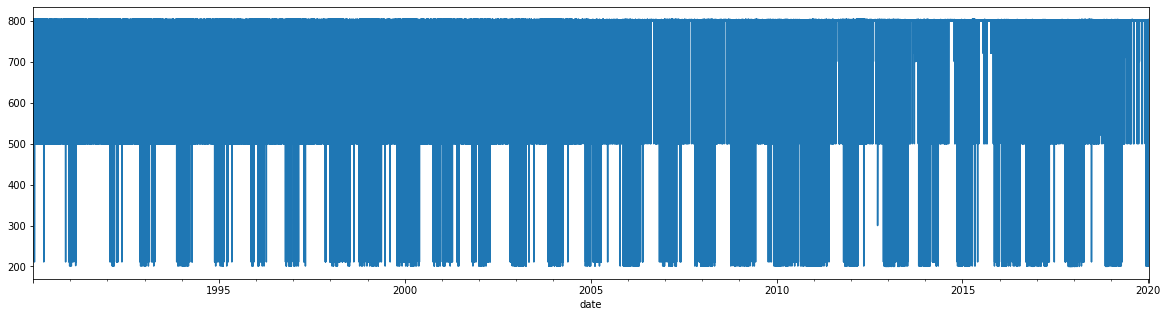

In [ ]:
clean_dataset.weather_id.plot(figsize=(20, 5));

## RESAMPLING DATASET

GOAL:
- Faster Training
- Easier For Interactive Visualization
- Practical Use

In [ ]:
clean_dataset.head()

temp  temp_min  temp_max  pressure  humidity  \
date                                                                       
1990-01-01 08:00:00+08:00  25.82     25.82     25.82    1010.0        86   
1990-01-01 09:00:00+08:00  26.20     26.20     26.20    1011.0        84   
1990-01-01 10:00:00+08:00  26.45     26.45     26.45    1011.0        84   
1990-01-01 11:00:00+08:00  26.80     26.80     26.80    1011.0        82   
1990-01-01 12:00:00+08:00  27.04     27.04     27.04    1010.0        82   

                           wind_speed  wind_deg  rain_1h  clouds_all  \
date                                                                   
1990-01-01 08:00:00+08:00        1.36       225     0.49          98   
1990-01-01 09:00:00+08:00        2.09       247     0.13          91   
1990-01-01 10:00:00+08:00        2.44       262     0.24          94   
1990-01-01 11:00:00+08:00        2.29       271     0.23          94   
1990-01-01 12:00:00+08:00        1.71       274     0.00          76   

                           weather_id  
date                                   
1990-01-01 08:00:00+08:00         500  
1990-01-01 09:00:00+08:00         500  
1990-01-01 10:00:00+08:00         500  
1990-01-01 11:00:00+08:00         500  
1990-01-01 12:00:00+08:00         803

In [ ]:
# resample to 24H / 1D

FREQ_RESAMPLE = '24H'

# resample for single column function (MEAN / SUM)

rs_apply_temp = np.mean 
rs_apply_pressure = np.mean
rs_apply_humidity = np.mean
rs_apply_rain = np.sum

_resample_single_column = clean_dataset.resample(FREQ_RESAMPLE).agg({
    'temp': rs_apply_temp,
    'temp_min': rs_apply_temp,
    'temp_max': rs_apply_temp,
    'pressure': rs_apply_pressure,
    'humidity': rs_apply_humidity,
    'rain_1h': rs_apply_rain,
})
_resample_single_column.head()

temp   temp_min   temp_max     pressure  \
date                                                                      
1990-01-01 00:00:00+08:00  26.781875  26.781875  26.781875  1009.312500   
1990-01-02 00:00:00+08:00  25.627500  25.627500  25.627500  1009.625000   
1990-01-03 00:00:00+08:00  26.392500  26.392500  26.392500  1008.958333   
1990-01-04 00:00:00+08:00  26.693333  26.693333  26.693333  1008.416667   
1990-01-05 00:00:00+08:00  27.650417  27.650417  27.650417  1007.458333   

                            humidity  rain_1h  
date                                           
1990-01-01 00:00:00+08:00  83.312500     3.13  
1990-01-02 00:00:00+08:00  87.541667    20.83  
1990-01-03 00:00:00+08:00  84.500000    25.33  
1990-01-04 00:00:00+08:00  83.791667    12.08  
1990-01-05 00:00:00+08:00  80.791667     0.54

In [ ]:
# resample the rest of columns based on wind_speed max

def rs_apply_multi(df):
    ix_max = df.wind_speed.idxmax()
    return df.loc[ix_max]

_columns_grouped_apply = 'wind_speed wind_deg clouds_all weather_id'.split()

_resample_multi_columns = (
    clean_dataset[_columns_grouped_apply]
    .groupby(pd.Grouper(freq=FREQ_RESAMPLE))
    .apply(rs_apply_multi)
)
_resample_multi_columns.head()

wind_speed  wind_deg  clouds_all  weather_id
date                                                                   
1990-01-01 00:00:00+08:00        2.91     219.0        71.0       500.0
1990-01-02 00:00:00+08:00        3.33     282.0       100.0       500.0
1990-01-03 00:00:00+08:00        4.14     258.0       100.0       501.0
1990-01-04 00:00:00+08:00        4.16     295.0       100.0       501.0
1990-01-05 00:00:00+08:00        5.28     356.0       100.0       804.0

In [ ]:
resample_dataset = pd.concat(
    [_resample_single_column, _resample_multi_columns], 
    axis='columns'
)
resample_dataset = resample_dataset[clean_dataset.columns]

# simplifying date format and removed timezone info
resample_dataset['new_date'] = pd.to_datetime(
    resample_dataset.index.strftime('%Y-%m-%d')
)
resample_dataset = resample_dataset.set_index('new_date').rename_axis('date')
resample_dataset

temp   temp_min   temp_max     pressure   humidity  \
date                                                                  
1990-01-01  26.781875  26.781875  26.781875  1009.312500  83.312500   
1990-01-02  25.627500  25.627500  25.627500  1009.625000  87.541667   
1990-01-03  26.392500  26.392500  26.392500  1008.958333  84.500000   
1990-01-04  26.693333  26.693333  26.693333  1008.416667  83.791667   
1990-01-05  27.650417  27.650417  27.650417  1007.458333  80.791667   
...               ...        ...        ...          ...        ...   
2020-01-04  28.125000  28.125000  28.125000  1006.000000  85.083333   
2020-01-05  29.208333  29.208333  29.208333  1006.791667  85.208333   
2020-01-06  28.416667  28.416667  28.416667  1007.583333  87.625000   
2020-01-07  28.541667  28.541667  28.541667  1007.125000  85.166667   
2020-01-08  27.750000  27.750000  27.750000  1007.250000  87.250000   

            wind_speed  wind_deg  rain_1h  clouds_all  weather_id  
date                                                               
1990-01-01        2.91     219.0     3.13        71.0       500.0  
1990-01-02        3.33     282.0    20.83       100.0       500.0  
1990-01-03        4.14     258.0    25.33       100.0       501.0  
1990-01-04        4.16     295.0    12.08       100.0       501.0  
1990-01-05        5.28     356.0     0.54       100.0       804.0  
...                ...       ...      ...         ...         ...  
2020-01-04       11.80     260.0     0.00        75.0       803.0  
2020-01-05        8.20     290.0     0.00        75.0       500.0  
2020-01-06        7.20     260.0     0.00        75.0       501.0  
2020-01-07        6.70     290.0     0.00        40.0       802.0  
2020-01-08        6.70     290.0     0.00        75.0       803.0  

[10965 rows x 10 columns]

### VISUALIZE DATASET (INTERACTIVE)

#### Temperature

In [ ]:
fig = px.line(
    resample_dataset,
    y=['temp', 'temp_min', 'temp_max'],
    title='Temperature',
)
fig.update_traces(opacity=0.5)
fig.show(renderer='colab')

#### Pressure

In [ ]:
fig = px.line(
    resample_dataset,
    y='pressure',
    title='Pressure',
)
fig.show(renderer='colab')

#### Humidity

In [ ]:
fig = px.line(
    resample_dataset,
    y='humidity',
    title='Humidity',
)
fig.show(renderer='colab')

#### Rain (24H)

In [ ]:
fig = px.line(
    resample_dataset,
    y='rain_1h',
    title='Rain 24 Hours',
)
fig.show(renderer='colab')

#### Cloudiness

In [ ]:
fig = px.histogram(
    resample_dataset, 
    x='clouds_all', nbins=20,
    title='Cloudiness'
)
fig.show(renderer='colab')

#### Weather ID

In [ ]:
_histogram_plotly = resample_dataset.agg(
    {'weather_id': lambda x: f"{int(x)}"}
)

fig = px.histogram(
    _histogram_plotly, 
    x='weather_id',
    title='Weather ID',
    log_y=True,
    category_orders=dict(
        weather_id=sorted(_histogram_plotly.weather_id.unique())
    )
)
fig.show(renderer='colab')

#### Windrose (Wind Degree & Wind Speed)

##### Using matplotlib

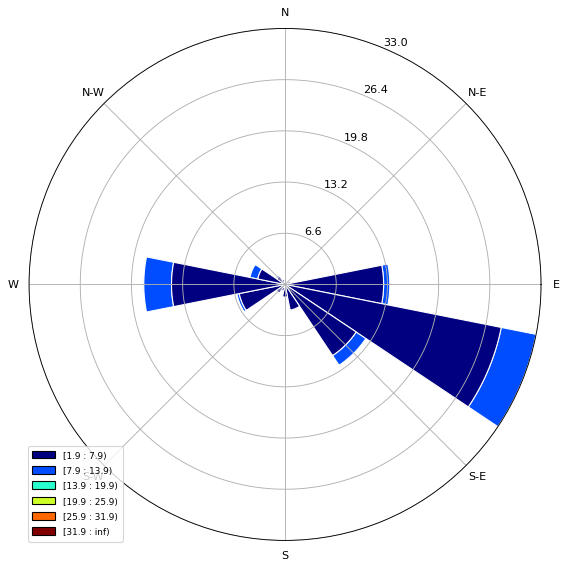

In [ ]:
ax = WindroseAxes.from_ax()
ax.bar(resample_dataset.wind_deg, resample_dataset.wind_speed, normed=True, opening=1, edgecolor='white')
ax.set_legend();

##### Using Plotly

###### Categorize Wind Degree to Wind Direction

![image](https://user-images.githubusercontent.com/1007910/178739063-384b5123-bced-47db-b476-76fe54c0a433.png)


In [ ]:
# http://snowfence.umn.edu/Components/winddirectionanddegrees.htm

degree_direction = [
    -np.inf, 11.25, 33.75, 56.25, 78.75, 101.25,
    123.75, 146.25, 168.75, 191.25, 213.75,
    236.25, 258.75, 281.25, 303.75, 326.25,
    348.75, 360
]

cardinal_direction = (
    "N NNE NE ENE E ESE SE SSE S SSW SW WSW W WNW NW NNW N2".split()
)

resample_dataset['wind_direction'] = pd.cut(
    resample_dataset.wind_deg, 
    degree_direction, 
    labels=cardinal_direction
)
resample_dataset.wind_direction = (
    resample_dataset
    .wind_direction
    .replace('N2', 'N')
)

resample_dataset['wind_strength'] = pd.cut(
    resample_dataset.wind_speed, 
    [-np.inf, 2, 4, 6, 8, 10, 12, 14, np.inf], 
    labels='0-2 2-4 4-6 6-8 8-10 10-12 12-14 14+'.split()
)

In [ ]:
windrose_plotly = (
    resample_dataset
    .groupby(['wind_direction', 'wind_strength'])
    .size()
    .reset_index(name='wind_frequency')
)

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler((0.05, 2.6))
x_scaled = min_max_scaler.fit_transform(
    windrose_plotly
    .wind_frequency
    .to_numpy()
    .reshape(-1, 1)
)
windrose_plotly['wind_freq_scaled'] = x_scaled.flatten()

###### Plotly

In [ ]:
fig = px.bar_polar(
    windrose_plotly.sort_values(['wind_strength', 'wind_direction']), 
    r='wind_freq_scaled', 
    theta='wind_direction', 
    color='wind_strength',
    template='plotly_dark', 
    color_discrete_sequence= px.colors.sequential.Plasma_r
)
fig.show(renderer='colab')

In [ ]:
fig = px.histogram(
    resample_dataset, 
    x='wind_direction',
    title='Wind Direction',
)
fig.show(renderer='colab')

In [ ]:
fig = px.histogram(
    resample_dataset, 
    x='wind_strength',
    title='Wind strength',
    category_orders=dict(
        wind_strength=(
            resample_dataset
            .wind_strength
            .cat.categories
            .values
        )
    )
)
fig.update_layout(xaxis_type='category')
fig.show(renderer='colab')

## FINAL DATASET

In [ ]:
dataset = resample_dataset.copy().drop(['weather_id', 'wind_deg', 'wind_speed'], axis='columns')
dataset = dataset.rename(
    dict(
        rain_1h='rain',
        clouds_all='cloud'
    ),
    axis='columns'
)

In [ ]:
# column prediction (target) (tomorrow / t+1)
dataset['rain_tmw'] = dataset.rain.shift(periods=-1)
dataset = dataset.dropna()

In [ ]:
dataset.head()

temp   temp_min   temp_max     pressure   humidity   rain  \
date                                                                         
1990-01-01  26.781875  26.781875  26.781875  1009.312500  83.312500   3.13   
1990-01-02  25.627500  25.627500  25.627500  1009.625000  87.541667  20.83   
1990-01-03  26.392500  26.392500  26.392500  1008.958333  84.500000  25.33   
1990-01-04  26.693333  26.693333  26.693333  1008.416667  83.791667  12.08   
1990-01-05  27.650417  27.650417  27.650417  1007.458333  80.791667   0.54   

            cloud wind_direction wind_strength  rain_tmw  
date                                                      
1990-01-01   71.0             SW           2-4     20.83  
1990-01-02  100.0            WNW           2-4     25.33  
1990-01-03  100.0            WSW           4-6     12.08  
1990-01-04  100.0            WNW           4-6      0.54  
1990-01-05  100.0              N           4-6      0.79

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10964 entries, 1990-01-01 to 2020-01-07
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   temp            10964 non-null  float64 
 1   temp_min        10964 non-null  float64 
 2   temp_max        10964 non-null  float64 
 3   pressure        10964 non-null  float64 
 4   humidity        10964 non-null  float64 
 5   rain            10964 non-null  float64 
 6   cloud           10964 non-null  float64 
 7   wind_direction  10964 non-null  category
 8   wind_strength   10964 non-null  category
 9   rain_tmw        10964 non-null  float64 
dtypes: category(2), float64(8)
memory usage: 793.3 KB


In [ ]:
dataset.describe()

temp      temp_min      temp_max      pressure      humidity  \
count  10964.000000  10964.000000  10964.000000  10964.000000  10964.000000   
mean      27.283327     27.158717     27.406774   1010.041804     80.771975   
std        1.061952      1.064038      1.084012      1.996238      4.256116   
min       22.406250     22.258333     22.570833   1001.216667     60.583333   
25%       26.543333     26.423125     26.645312   1008.720833     78.083333   
50%       27.349167     27.229167     27.466875   1010.129167     80.916667   
75%       28.061667     27.937188     28.200000   1011.479167     83.666667   
max       30.947500     30.947500     30.947500   1016.762500     97.750000   

               rain         cloud      rain_tmw  
count  10964.000000  10964.000000  10964.000000  
mean       0.698853     40.784112      0.698567  
std        2.310104     25.826663      2.309997  
min        0.000000      0.000000      0.000000  
25%        0.000000     20.000000      0.000000  
50%        0.000000     40.000000      0.000000  
75%        0.380000     50.250000      0.380000  
max       57.300000    100.000000     57.300000

## DATA PREPROCESSING

In [ ]:
prep_dataset = (
    dataset
    .dropna(axis=0, how='any')
    .drop('rain_tmw', axis='columns')
    .copy()
)
prep_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10964 entries, 1990-01-01 to 2020-01-07
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   temp            10964 non-null  float64 
 1   temp_min        10964 non-null  float64 
 2   temp_max        10964 non-null  float64 
 3   pressure        10964 non-null  float64 
 4   humidity        10964 non-null  float64 
 5   rain            10964 non-null  float64 
 6   cloud           10964 non-null  float64 
 7   wind_direction  10964 non-null  category
 8   wind_strength   10964 non-null  category
dtypes: category(2), float64(7)
memory usage: 707.7 KB


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding for wind_direction & wind_strength

le_wind_direction = LabelEncoder()
le_wind_strength = LabelEncoder()

prep_dataset.wind_direction = le_wind_direction.fit_transform(dataset.wind_direction)
prep_dataset.wind_strength = le_wind_strength.fit_transform(dataset.wind_strength)
prep_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10964 entries, 1990-01-01 to 2020-01-07
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temp            10964 non-null  float64
 1   temp_min        10964 non-null  float64
 2   temp_max        10964 non-null  float64
 3   pressure        10964 non-null  float64
 4   humidity        10964 non-null  float64
 5   rain            10964 non-null  float64
 6   cloud           10964 non-null  float64
 7   wind_direction  10964 non-null  int64  
 8   wind_strength   10964 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 856.6 KB


In [ ]:
SPLIT_DATE_TRAIN_START = None
SPLIT_DATE_TRAIN_END = '20101231'
SPLIT_DATE_TEST_START = '20110101'
SPLIT_DATE_TEST_END = None

train_dataset = prep_dataset.loc[SPLIT_DATE_TRAIN_START:SPLIT_DATE_TRAIN_END].copy()
test_dataset = prep_dataset.loc[SPLIT_DATE_TEST_START:SPLIT_DATE_TEST_END].copy()

In [ ]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7670 entries, 1990-01-01 to 2010-12-31
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temp            7670 non-null   float64
 1   temp_min        7670 non-null   float64
 2   temp_max        7670 non-null   float64
 3   pressure        7670 non-null   float64
 4   humidity        7670 non-null   float64
 5   rain            7670 non-null   float64
 6   cloud           7670 non-null   float64
 7   wind_direction  7670 non-null   int64  
 8   wind_strength   7670 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 599.2 KB


In [ ]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3294 entries, 2011-01-01 to 2020-01-07
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temp            3294 non-null   float64
 1   temp_min        3294 non-null   float64
 2   temp_max        3294 non-null   float64
 3   pressure        3294 non-null   float64
 4   humidity        3294 non-null   float64
 5   rain            3294 non-null   float64
 6   cloud           3294 non-null   float64
 7   wind_direction  3294 non-null   int64  
 8   wind_strength   3294 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 257.3 KB


In [ ]:
column_trans = ColumnTransformer(
    [
        ('temp', MinMaxScaler(), ['temp']),
        ('temp_min', MinMaxScaler(), ['temp_min']),
        ('temp_max', MinMaxScaler(), ['temp_max']),
        ('pressure', StandardScaler(), ['pressure']),
        ('humidity', MinMaxScaler(), ['humidity']),
        ('rain', MinMaxScaler(), ['rain']),
        ('cloud', MinMaxScaler(), ['cloud']),
        # ('wind_direction', MinMaxScaler(), ['wind_direction']),
        # ('wind_strength', MinMaxScaler(), ['wind_strength']),
        # ('rain_tmw', MinMaxScaler(), ['rain_tmw']),
    ],
    verbose=True, remainder='passthrough'
)

In [ ]:
transformed_train_dataset = pd.DataFrame(
    column_trans.fit_transform(train_dataset), 
    columns=train_dataset.columns,
    index=train_dataset.index
)
transformed_test_dataset = pd.DataFrame(
    column_trans.transform(test_dataset),
    columns=test_dataset.columns,
    index=test_dataset.index
)

[ColumnTransformer] .......... (1 of 8) Processing temp, total=   0.0s
[ColumnTransformer] ...... (2 of 8) Processing temp_min, total=   0.0s
[ColumnTransformer] ...... (3 of 8) Processing temp_max, total=   0.0s
[ColumnTransformer] ...... (4 of 8) Processing pressure, total=   0.0s
[ColumnTransformer] ...... (5 of 8) Processing humidity, total=   0.0s
[ColumnTransformer] .......... (6 of 8) Processing rain, total=   0.0s
[ColumnTransformer] ......... (7 of 8) Processing cloud, total=   0.0s
[ColumnTransformer] ..... (8 of 8) Processing remainder, total=   0.0s


In [ ]:
transformed_train_dataset

temp  temp_min  temp_max  pressure  humidity      rain  cloud  \
date                                                                            
1990-01-01  0.443377  0.471982  0.436475 -0.412016  0.642521  0.054625   0.71   
1990-01-02  0.289126  0.325658  0.280311 -0.251555  0.762073  0.363525   1.00   
1990-01-03  0.391348  0.422626  0.383800 -0.593871  0.676090  0.442059   1.00   
1990-01-04  0.431546  0.460758  0.424497 -0.872003  0.656066  0.210820   1.00   
1990-01-05  0.559434  0.582075  0.553971 -1.364082  0.571260  0.009424   1.00   
...              ...       ...       ...       ...       ...       ...    ...   
2010-12-27  0.549524  0.548748  0.568006 -2.562188  0.570082  0.000000   0.40   
2010-12-28  0.323479  0.319003  0.367341 -2.324707  0.717314  0.000000   0.40   
2010-12-29  0.415957  0.414070  0.440618 -1.890393  0.687868  0.000000   0.75   
2010-12-30  0.460999  0.464244  0.478947 -2.095783  0.724382  0.000000   0.75   
2010-12-31  0.619843  0.605789  0.654247 -3.139847  0.692580  0.000000   0.75   

            wind_direction  wind_strength  
date                                       
1990-01-01            12.0            4.0  
1990-01-02            14.0            4.0  
1990-01-03            15.0            5.0  
1990-01-04            14.0            5.0  
1990-01-05             3.0            5.0  
...                    ...            ...  
2010-12-27            14.0            7.0  
2010-12-28            13.0            7.0  
2010-12-29            13.0            7.0  
2010-12-30            14.0            6.0  
2010-12-31             0.0            5.0  

[7670 rows x 9 columns]

In [ ]:
transformed_test_dataset

temp  temp_min  temp_max  pressure  humidity  rain  cloud  \
date                                                                        
2011-01-01  0.380213  0.384494  0.398906 -3.161241  0.800942   0.0   0.40   
2011-01-02  0.567674  0.556142  0.599572 -2.384612  0.557126   0.0   0.40   
2011-01-03  0.505707  0.493292  0.540387 -2.089364  0.718492   0.0   0.40   
2011-01-04  0.476254  0.468469  0.506567 -2.132154  0.681979   0.0   0.40   
2011-01-05  0.519125  0.509665  0.551660 -2.429541  0.639576   0.0   0.40   
...              ...       ...       ...       ...       ...   ...    ...   
2020-01-03  0.656255  0.673920  0.651993 -0.893398  0.689046   0.0   0.75   
2020-01-04  0.622850  0.642231  0.618173 -2.112899  0.692580   0.0   0.75   
2020-01-05  0.767608  0.779550  0.764726 -1.706398  0.696113   0.0   0.75   
2020-01-06  0.661823  0.679201  0.657629 -1.299898  0.764429   0.0   0.75   
2020-01-07  0.678526  0.695046  0.674539 -1.535240  0.694935   0.0   0.40   

            wind_direction  wind_strength  
date                                       
2011-01-01             1.0            4.0  
2011-01-02            14.0            5.0  
2011-01-03             4.0            5.0  
2011-01-04            13.0            5.0  
2011-01-05             5.0            7.0  
...                    ...            ...  
2020-01-03            13.0            6.0  
2020-01-04            13.0            1.0  
2020-01-05            14.0            7.0  
2020-01-06            13.0            6.0  
2020-01-07            14.0            6.0  

[3294 rows x 9 columns]

## INPUT TENSOR

In [ ]:
TIMESTEPS = 10

X_train, y_train = hk53.tensor_array(
    transformed_train_dataset, timesteps=TIMESTEPS,
    X_columns=None, y_out=True, y_columns=['rain']
)

X_test, y_test = hk53.tensor_array(
    transformed_test_dataset, timesteps=TIMESTEPS,
    X_columns=None, y_out=True, y_columns=['rain']
)

In [ ]:
X_train.shape, y_train.shape

((7660, 10, 9), (7660,))

In [ ]:
X_test.shape, y_test.shape

((3284, 10, 9), (3284,))

## MODEL

In [ ]:
tf.keras.backend.clear_session()
lstm_model = Sequential()
lstm_model.add(LSTM(128, return_sequences=True, input_shape=(TIMESTEPS, X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64, return_sequences=False))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1))
# lstm_model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape', 'msle', 'cosine_similarity', 'logcosh'])
lstm_model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           70656     
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 120,129
Trainable params: 120,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

Epoch 1/10
479/479 [==============================] - 12s 7ms/step - loss: 0.0049 - mae: 0.0419 - mape: 18370850.0000
Epoch 2/10
479/479 [==============================] - 3s 7ms/step - loss: 0.0022 - mae: 0.0252 - mape: 9651515.0000
Epoch 3/10
479/479 [==============================] - 3s 7ms/step - loss: 0.0019 - mae: 0.0222 - mape: 7871501.5000
Epoch 4/10
479/479 [==============================] - 3s 7ms/step - loss: 0.0018 - mae: 0.0206 - mape: 7115734.0000
Epoch 5/10
479/479 [==============================] - 3s 7ms/step - loss: 0.0018 - mae: 0.0201 - mape: 6739786.5000
Epoch 6/10
479/479 [==============================] - 4s 7ms/step - loss: 0.0017 - mae: 0.0192 - mape: 6115336.0000
Epoch 7/10
479/479 [==============================] - 4s 8ms/step - loss: 0.0017 - mae: 0.0184 - mape: 5756936.0000
Epoch 8/10
479/479 [==============================] - 3s 7ms/step - loss: 0.0017 - mae: 0.0182 - mape: 5503596.5000
Epoch 9/10
479/479 [==============================] - 3s 7ms/step - lo

## EVAL (VISUALIZATION)

### HISTORY

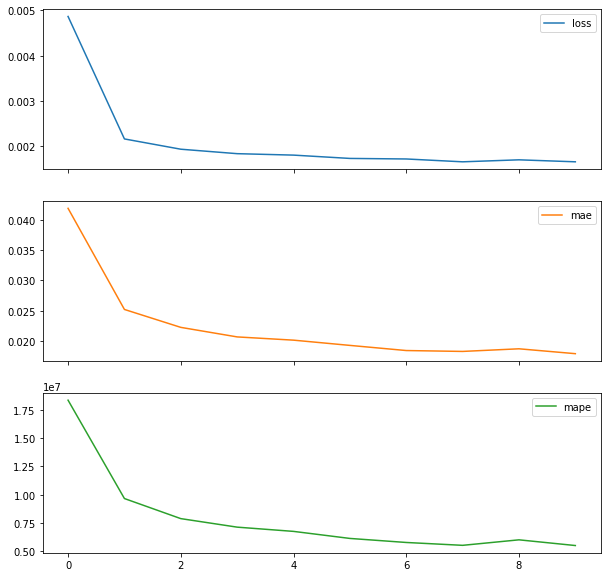

In [ ]:
pd.DataFrame(history.history).plot(subplots=True, figsize=(10, 10));

### TRAIN

In [ ]:
class PlotModel:
    def __init__(self, X, y, timesteps, transformed_dataset):

        rain_scaler = column_trans.named_transformers_['rain']
        index_date = transformed_dataset.index[timesteps:]

        self.y_predict = lstm_model.predict(X)
        self.y_observation = y

        self.real_predict = rain_scaler.inverse_transform(
            self.y_predict.reshape(-1, 1)
        )
        self.real_observation = rain_scaler.inverse_transform(
            self.y_observation.reshape(-1, 1)
        )

        self.df_predict = pd.DataFrame(
            self.real_predict, columns=['predict'], index=index_date
        )
        self.df_observation = pd.DataFrame(
            self.real_observation, columns=['observation'], index=index_date
        )

        self.combined_df = pd.concat(
            (self.df_predict, self.df_observation), axis='columns'
        )

    def line(self):
        fig = px.line(self.combined_df)
        fig.update_layout(
            hovermode='x'
        )
        return fig

    def r_squared(self):
        fig = px.scatter(
            self.combined_df, x='predict', y='observation', 
            trendline='ols'
        )
        fig.update_layout(
            autosize=False,
            width=800,
            height=500
        )
        return fig

plot_train = PlotModel(X_train, y_train, TIMESTEPS, transformed_train_dataset)
plot_train.line()

In [ ]:
plot_train.r_squared()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



### TEST

In [ ]:
plot_test = PlotModel(X_test, y_test, TIMESTEPS, transformed_test_dataset)
plot_test.line()

In [ ]:
plot_test.r_squared()

## CONCLUSION

Dari percobaan diatas dapat disimpulkan bahwa:

- Pemodelan LSTM untuk memprediksikan hujan esok hari (dengan volume 24 jam) hasilnya tidak memuaskan.
- Nilai MSE (Loss) untuk setiap iterasi memiliki selisih yang kecil dan tidak signifikan. Maka, bisa diasumsikan bahwa penggunaan MSE sebagai loss tidak tepat atau bukan metrik yang tepat untuk kasus yang diterapkan.

Saran:

- Perlu dilakukan konfigurasi/arsitektur model dengan memvariasikan jumlah layer, aktivasi, dan hyperparameter lainnya.
- Melakukan pemodelan LSTM dengan resolusi yang lebih kecil.
- Melakukan _feature engineering_ untuk memperoleh penggunaan fitur yang mampu memprediksikan target yang lebih akurat.
- Memilih target selain hujan. 